# Assignment 4 - DDPG

During labs you have learnt about DQN - an algorithm for solving discrete action environments.
In this task you will implement DDPG which can be thought of as DQN variation for environments with continuous action space.


Here is the pesudocode from the original work: 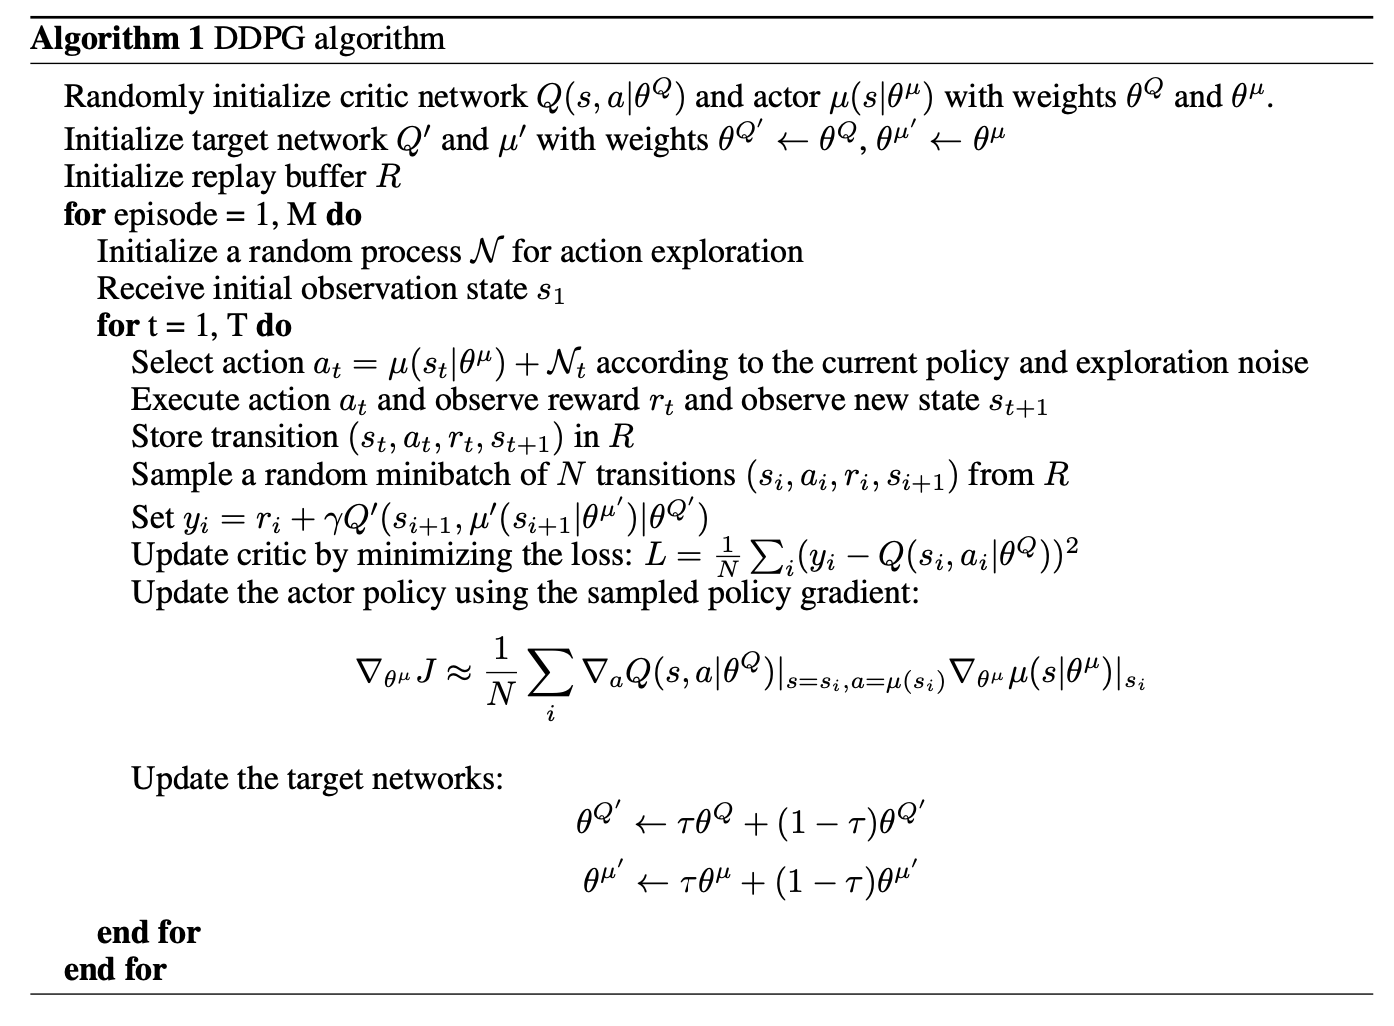

### Resources

- [openai/gym](https://gym.openai.com/docs/)
- [getting-started-with-openai-gym](https://blog.paperspace.com/getting-started-with-openai-gym/)
- [Continuous control with deep reinforcement learning (DDPG)](https://arxiv.org/abs/1509.02971)
- [Deterministic Policy Gradient Algorithms](http://proceedings.mlr.press/v32/silver14.pdf)

You can read about actor policy update step and how to implement it here:
- https://www.quora.com/Why-is-the-loss-for-DDPG-Actor-the-product-of-gradients-of-Q-values-actions
- https://stackoverflow.com/questions/51496159/ddpg-deep-deterministic-policy-gradients-how-is-the-actor-updated


## Requirements

1. Experiments reproducability:

    You should ensure that you can re-run your experiments and obtain the same results. To do so implement `set_seed` function that handles necessary logic. Pick one of the experiments (short one) and re-run it with logging of the losses/mean_rewards to show that results are reproduced.

2. Implement Polyak average for updating network's parameters:

    During labs about DQN you have seen that target's network parameters can be updated every K steps by overwritting old parameters. There are other, more robust, methods to do so. One of the most popular is polyak average (weighted moving average). Your tasks will be to implement it as well.

3. Implement DDPG algorithm:

    Read paper carefully, and don't forget about exploration.

4. Environments:

    Solve the environmets listed below and reach the corresponding benchmark score.

5. Analysis of different hyperparameters.

    Pick one of the environments and repeat the training 5 times with a different subset of hyperparameters such that the results differ. Present comparison of used parameters' configurations, training summary, plots, and your conclusions.

    Tip: RL algorithms are especially parameter sensitive. It's a good occasion to ponder how to organize your work such that you can easily track and compare different runs and configurations. Organize your experiments or use a utility such as [tensorboard](https://pytorch.org/docs/stable/tensorboard.html), [neptune](neptune.ai), [wandb](wandb.ai) or [clearml](https://clear.ml/).


### Evaluation & Grading

Total points: 12
- Seed initalization & experiment reproducibility [0.5]
- Polyak average [0.5]
- Gaussian noise [0.5]
- DDPG [5.5]
- Solving environments (benchmark) [3.0]
- Analysis of different hyperparameters [2.0]

#### Benchmark
For each of the following environments you should train one agent and obtain at least the following mean score in our benchmark:
```
"Pendulum-v1" : -160,
"LunarLanderContinuous-v2": 130,
"MountainCarContinuous-v0": 80
```

# Environment setup, helper functions & classes

Remember to restart your runtime after installing the packages.

In [ ]:
import copy
import random
import numpy as np
import torch
import torch.nn as nn
from typing import List, Optional, Callable, Tuple
from collections import namedtuple
import imageio
from pathlib import Path
import gym
from pyvirtualdisplay import Display
from clearml import Task

/usr/local/lib/python3.7/dist-packages/ale_py/roms/utils.py:90: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for external in metadata.entry_points().get(self.group, []):


In [ ]:
web_server = 'https://app.community.clear.ml'
api_server = 'https://api.community.clear.ml'
files_server = 'https://files.community.clear.ml'

Task.set_credentials(web_host=web_server,
                     api_host=api_server,
                     files_host=files_server,
                     key=access_key,
                     secret=secret_key)

### Benchmark

Don't modify Benchmark's cell. Your solution should pass the proposed thresholds.

In [ ]:
def as_tensor(data: np.ndarray, dtype=torch.float32, batch: bool = False) -> torch.Tensor:
    tensor = torch.tensor(data, dtype=dtype, device=DEVICE)
    if batch and len(tensor.shape) == 1:
        tensor = tensor.unsqueeze(dim=1)
    return tensor

class Benchmark:
    def __init__(self):
        """ Don't modify. Your agent should pass those benchmarks. """
        self.env_to_mean_score = {
            "Pendulum-v1" : -160,
            "LunarLanderContinuous-v2": 130,
            "MountainCarContinuous-v0": 80
        }
        self.n_episodes = 100
        self.seed = 42
    
    def run(self, env_id: str, policy) -> None:
        env = gym.make(env_id)
        stats = self._eval(env, policy, self.n_episodes, self.seed)
        score = np.mean(stats["episodes_rews"])
        result = "Success" if score > self.env_to_mean_score[env_id] else "Failure"
        print(f"{result} on {env_id} with mean score: {score}")
        assert len(stats["episodes_rews"]) == self.n_episodes

    def _eval(self, env, policy, n_episodes: int = 100, seed: Optional[int] = None):
        print("\nStarting Benchmark:")
        print("seed:", seed)
        print("n_episodes:", n_episodes)
        if seed: # Be careful, this will reset your rng!
            set_seeds(env, seed)

        stats = {
            "episodes_rews": [],
            "episodes_lens": [],
        }
        
        for episode in range(n_episodes):
            done = False
            obs = env.reset()
            ep_rew, ep_len = 0, 0

            while not done:
                with torch.no_grad():
                    action = policy(as_tensor(obs)).cpu().numpy() # No exploration noise during evalution!
                obs, reward, done, _ = env.step(action)
                ep_rew += reward
                ep_len += 1
            
            stats["episodes_lens"].append(ep_len)
            stats["episodes_rews"].append(ep_rew)

        print("Rewards:", stats["episodes_rews"])
        print("Lengths:", stats["episodes_lens"])
        print("Mean episode reward:", np.mean(stats["episodes_rews"]))
        print("Mean episode length:", np.mean(stats["episodes_lens"]))

        return stats

### Utilities

A few helper functions to help you get started.

In [ ]:
def eval(env, policy, n_episodes: int = 100, seed: Optional[int] = None):
    """ Helper method to evaluate agent """
    if seed: # Be careful, this will reset your rng!
        set_seeds(env, seed)

    stats = {
        "episodes_rews": [],
        "episodes_lens": [],
    }
    
    for episode in range(n_episodes):
        done = False
        obs = env.reset()
        ep_rew, ep_len = 0, 0

        while not done:
            with torch.no_grad():
                action = policy(as_tensor(obs)).cpu().numpy() # No exploration noise during evalution
            obs, reward, done, _ = env.step(action)
            ep_rew += reward
            ep_len += 1
        
        stats["episodes_lens"].append(ep_len)
        stats["episodes_rews"].append(ep_rew)

    print("Rewards:", stats["episodes_rews"])
    print("Lengths:", stats["episodes_lens"])
    print("Mean episode reward:", np.mean(stats["episodes_rews"]))
    print("Mean episode length:", np.mean(stats["episodes_lens"]))

    return stats

In [ ]:
def make_gif(env_id, actor = None, n_episodes: int = 1, gif_name: str = "agent.gif", dir: str = "./gifs"):
    """ 
    Create a gif of an agent interacting with an environment.
    Note: It does not always work in Google colab, and crashes from time to time.
    """
    display = Display(visible=0, size=(1400, 900))
    display.start()

    Path(dir).mkdir(parents=True, exist_ok=True)
    filename = Path(dir).joinpath(gif_name)

    images = []
    env = gym.make(env_id)
    for _ in range(n_episodes):
        obs, done = env.reset(), False
        images.append(env.render("rgb_array"))
        while not done:
            if actor:
                with torch.no_grad():
                    action = actor(as_tensor(obs)).cpu().numpy()
            else:
                action = env.action_space.sample() 
            obs, reward, done, _ = env.step(action) 
            images.append(env.render("rgb_array"))

    imageio.mimsave(filename, images, fps=29)

In [ ]:
def try_gpu(i: int = 0) -> None:
    """ Return gpu(i) if exists, otherwise return cpu() """
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

In gym environments Box(n,) corresponds to the n-dimensional continuous space. The observation space has upper and lower bounds that describe the range of values it can take.

In [ ]:
def describe_env(env_id: str) -> None:
    print(env_id)
    env = gym.make(env_id)
    spec = gym.spec(env_id)
    print(f"Environment: {env_id}")
    print(f"Observation Space: {env.observation_space}")
    print(f"Observation Space High: {env.observation_space.high}")
    print(f"Observation Space Low: {env.observation_space.low}")
    print(f"Action Space: {env.action_space}")
    print(f"Max Episode Steps: {spec.max_episode_steps}")
    print(f"Nondeterministic: {spec.nondeterministic}")
    print(f"Reward Range: {env.reward_range}")
    print(f"Reward Threshold: {spec.reward_threshold}")

continuous_envs = ["Pendulum-v1", "LunarLanderContinuous-v2", "MountainCarContinuous-v0"]

print(80*"#" + "\n")
for i, env in enumerate(continuous_envs):
    describe_env(env)
    print("\n" + 80*"#" + "\n")

################################################################################

Pendulum-v1
Environment: Pendulum-v1
Observation Space: Box([-1. -1. -8.], [1. 1. 8.], (3,), float32)
Observation Space High: [1. 1. 8.]
Observation Space Low: [-1. -1. -8.]
Action Space: Box([-2.], [2.], (1,), float32)
Max Episode Steps: 200
Nondeterministic: False
Reward Range: (-inf, inf)
Reward Threshold: None

################################################################################

LunarLanderContinuous-v2
Environment: LunarLanderContinuous-v2
Observation Space: Box([-inf -inf -inf -inf -inf -inf -inf -inf], [inf inf inf inf inf inf inf inf], (8,), float32)
Observation Space High: [inf inf inf inf inf inf inf inf]
Observation Space Low: [-inf -inf -inf -inf -inf -inf -inf -inf]
Action Space: Box([-1. -1.], [1. 1.], (2,), float32)
Max Episode Steps: 1000
Nondeterministic: False
Reward Range: (-inf, inf)
Reward Threshold: 200

###################################################################

In [ ]:
# is_terminal is a mask indicating whether the state is terminal or not
# it is useful when using target_net for predicting qvalues.
Transition = namedtuple("Transition",
                        ("state", "action", "next_state", "reward", "is_terminal"))

class ReplayBuffer(object):
    def __init__(self, size: int):
        """ Create new replay buffer.

        Args:
            size: capacity of the buffer
        """
        self._storage = []
        self._capacity = size
        self._next_idx = 0

    def add(self, transition: Transition) -> None:
        if len(self._storage) < self._capacity:
            self._storage.append(None)
        self._storage[self._next_idx] = transition
        self._next_idx = (self._next_idx + 1) % self._capacity

    def sample(self, batch_size: int) -> List[Transition]:
        """ Sample batch of experience from memory.

        Args:
            batch_size: size of the batch

        Returns:
            batch of transitions
        """
        batch = random.sample(self._storage, batch_size)
        return batch

    def __len__(self) -> int:
        return len(self._storage)

In [ ]:
class MLP(nn.Module):
    """ Simple MLP net.

    Each of the layers, despite the last one, is followed by `activation`, and the last one
    is optionally followed by `output_activation`.
    """
    def __init__(self, layers_sizes: List[int], activation: nn.Module = nn.ReLU, output_activation: Optional[nn.Module] = None) -> None:
        super(MLP, self).__init__()

        modules = []
        for in_features, out_features in zip(layers_sizes, layers_sizes[1:-1]):
            modules.extend([
                nn.Linear(in_features, out_features),
                activation()
            ])
        modules.extend([nn.Linear(layers_sizes[-2], layers_sizes[-1])])
        if output_activation:
            modules.extend([output_activation()])
        self.layers = nn.Sequential(*modules)

    def forward(self, obs: torch.Tensor) -> torch.Tensor:
        return self.layers(obs)

    def save(self, path: str) -> None:
        torch.save(self.state_dict(), path)

    def load(self, path: str) -> None:
        self.load_state_dict(torch.load(path))

In [ ]:
class Actor(MLP):
    def __init__(self, action_scale: float, *args, **kwargs):
        """
        Sometimes environment's have action range bigger than (-1, 1). 
        Thus we want to scale it appropriately to cover the whole range. Here we assume that the
        final layer is Tanh so scaling the output is enough.
        """
        super(Actor, self).__init__(*args, **kwargs)
        self.action_scale = action_scale

    def forward(self, obs: torch.Tensor) -> torch.Tensor:
        # action space 2 dla pendulum 1 dla reszty
        return self.action_scale * super().forward(obs)

# Solution

## Code

In [ ]:
def set_seeds(env: gym.Env, seed=42) -> None:
    """
    Set random seeds for reproduceability.
    See: https://pytorch.org/docs/stable/notes/randomness.html
         https://harald.co/2019/07/30/reproducibility-issues-using-openai-gym/
    """
    torch.manual_seed(seed)
    env.seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    env.action_space.seed(seed)

In [ ]:
def polyak_average(net1: nn.Module, net2: nn.Module, tau: float) -> None:
    """ 
    Update parameters of net1 with parameters of net2 as a weighted sum of both.
    """
    for target_param, param in zip(net1.parameters(), net2.parameters()):
            target_param.data.copy_(param.data * (1.0 - tau) + target_param.data * tau)

In [ ]:
def test_polyak_average():
    net1, net2 = MLP([2, 2]), MLP([2, 2])
    with torch.no_grad():
        net1.layers[0].weight.fill_(1)
        net1.layers[0].bias.fill_(1)
        net2.layers[0].weight.fill_(-1) 
        net2.layers[0].bias.fill_(0.5)
    print(list(net1.named_parameters())) 
    print(list(net2.named_parameters())) 
    polyak_average(net1, net2, tau=0.9)
    print(list(net1.named_parameters())) 

    expected_weight = torch.tensor([[0.8, 0.8], [0.8, 0.8]])
    expected_bias = torch.tensor([0.95, 0.95])
    assert torch.allclose(net1.layers[0].weight.data, expected_weight)
    assert torch.allclose(net1.layers[0].bias.data, expected_bias)

test_polyak_average()

[('layers.0.weight', Parameter containing:
tensor([[1., 1.],
        [1., 1.]], requires_grad=True)), ('layers.0.bias', Parameter containing:
tensor([1., 1.], requires_grad=True))]
[('layers.0.weight', Parameter containing:
tensor([[-1., -1.],
        [-1., -1.]], requires_grad=True)), ('layers.0.bias', Parameter containing:
tensor([0.5000, 0.5000], requires_grad=True))]
[('layers.0.weight', Parameter containing:
tensor([[0.8000, 0.8000],
        [0.8000, 0.8000]], requires_grad=True)), ('layers.0.bias', Parameter containing:
tensor([0.9500, 0.9500], requires_grad=True))]


In [ ]:
def gaussian_action_noise(action_dim: np.ndarray, mean: float, std: float) -> Callable[[], float]:
    """
    Returns function that samples noise of shape action_dim from the normal distribution N(mean, std) 
    """
    return torch.normal(mean=mean, std=std, size=action_dim)

In [ ]:
import torch.optim as optim
import matplotlib.pyplot as plt 

In [ ]:
def ddpg(env: gym.Env, actor, critic, actor_optim, critic_optim, 
         action_noise: Callable[[], float], total_steps: int, 
         buffer_size: int, batch_size: int, 
         gamma: float, polyak: float, initial_exploration_steps: int,
         actor_target, critic_target, noise=0.1):
    # Initialize necessary objects for the training
    
    rewards      = []
    finished     = 0
    criterion    = nn.MSELoss().to(device)
    memory       = ReplayBuffer(buffer_size)

    action_min, action_max = env.action_space.low, env.action_space.high

    
    def get_action(obs):
        """ 
        Calculate next action with exploration via Gaussian noise
        Remember to:
        1. Not calculate gradients for this forward pass.
        2. Include exploration noise.
        3. Clip action to fit within the environment's action space after adding the noise. 
        """
        state = obs.float().to(device)
        actor.eval()
        with torch.no_grad():
            current_action = actor(state)
        actor.train()
        current_action += gaussian_action_noise(current_action.shape, 0.0, noise).to(DEVICE)
        return np.clip(current_action.cpu().detach(), a_min=action_min, a_max=action_max)

    def critic_loss(batch):
        """
        Calculate critic's loss for a given batch.
        """

        Qvals = critic.forward(torch.cat([batch.state, batch.action], 1))
        next_actions = actor_target.forward(batch.next_state)
        next_Q = critic_target.forward(torch.cat([batch.next_state, next_actions.detach()], 1))
        Qprime = batch.reward + gamma * next_Q
        critic_loss = criterion(Qvals, Qprime)
        return critic_loss

    def actor_loss(batch):
        """
        Calculate actor's loss for a given batch.
        Remember that we want to maximize qvalue returned by critic, which represents the expected 
        future reward. Therefore, we want to do gradient ascent. However, optimizer always performs 
        gradient descent.
        """
        actor_loss = -critic.forward(torch.cat([batch.state, actor.forward(batch.state)], 1)).mean()
        return actor_loss

    def update_step():
        # Sample minibatch
        transitions = memory.sample(batch_size)
        # Convert from list of tuples to tuple of lists
        batch = Transition(*zip(*transitions))

        batch = Transition(as_tensor(batch.state, batch=True), 
                           as_tensor(batch.action, batch=True),
                           as_tensor(batch.next_state, batch=True),
                           as_tensor(batch.reward, batch=True),
                           as_tensor(batch.is_terminal, batch=True))

        # Critic step ~ 4/5 lines
        curr_critic_loss = critic_loss(batch)
        critic_optim.zero_grad()
        curr_critic_loss.backward() 
        critic_optim.step()

        # Actor step ~ 4/5 lines
        curr_actor_loss = actor_loss(batch)
        actor_optim.zero_grad()
        curr_actor_loss.backward()
        actor_optim.step()

        # Update target networks ~ 2 lines
        polyak_average(actor_target, actor, polyak)
        polyak_average(critic_target, critic, polyak)

        return curr_critic_loss.item(), curr_actor_loss.item()

    obs = env.reset()
    episode_reward = 0
    rewards_sum = 0
    critic_loss_sum = 0
    actor_loss_sum = 0
    step_num = 0
    for step in range(total_steps):
        # At the beginning explore randomly before using policy. This helps with exploration.
        if step < initial_exploration_steps:
            action = env.action_space.sample()
        else:
            action = get_action(as_tensor(obs)).cpu().numpy()
        
        # Interaction with the environment, updates, logs.
        new_state, reward, done, _ = env.step(action) 

        memory.add(Transition(state=obs, action=action, next_state=new_state, reward=reward, is_terminal=done))

        if len(memory) > batch_size:
            crit_loss, act_loss = update_step()
            critic_loss_sum += crit_loss
            actor_loss_sum += act_loss

        obs = new_state
        episode_reward += reward
        step_num += 1

        if done:
            rewards.append(episode_reward)
            finished += 1
            rewards_sum += episode_reward
            if finished % 50 == 0:
              logger.report_scalar(title='Rewards', series='Train', iteration=finished, value=rewards_sum/50)
              logger.report_scalar(title='Step len', series='Train', iteration=finished, value=step_num/50)
              logger.report_scalar(title='Critic loss', series='Loss', iteration=finished, value=critic_loss_sum/50)
              logger.report_scalar(title='Actor loss', series='Loss', iteration=finished, value=actor_loss_sum/50)
              eval_stats = eval(env, actor, n_episodes=20)
              logger.report_scalar(title='Rewards', series='Eval', iteration=finished, value=np.mean(eval_stats["episodes_rews"]))
              logger.report_scalar(title='Step len', series='Eval', iteration=finished, value=np.mean(eval_stats["episodes_lens"]))
              step_num = 0
              critic_loss_sum = 0
              actor_loss_sum = 0
              rewards_sum = 0
            print(step, episode_reward)
            episode_reward = 0
            obs = env.reset()

    range_epochs = range(finished)
    plt.plot(range_epochs, rewards)
    plt.title('Test loss')
    plt.xlabel('Epochs')
    plt.ylabel('BCELoss')
    plt.show()

# Training

## Pendulum

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  


199 -926.5542263549987
399 -1466.9228037946584
599 -897.1821603882289
799 -1461.814827905944
999 -1304.0903054360572
1199 -1111.612405077044
1399 -1301.0778526404872
1599 -1037.005323626276
1799 -885.7054909421906
1999 -1686.1651012785178
2199 -1550.1154671592496
2399 -1467.8875288645356
2599 -1748.3470797676268
2799 -1470.1191994438468
2999 -1194.042965775507
3199 -1177.8015667978166
3399 -1629.1670409487303
3599 -1541.6462737420693
3799 -1475.481208744415
3999 -1473.1777477417
4199 -1359.2947809445423
4399 -1440.6779107791751
4599 -870.8875897325858
4799 -1159.1069159200872
4999 -1071.647414750218
5199 -1514.0107501079192
5399 -1721.5226639564396
5599 -1554.3016160963928
5799 -1319.7539826895004
5999 -1598.4005422211264
6199 -1304.9054041574752
6399 -1082.167181096976
6599 -1692.3709885979101
6799 -1055.8782675740288
6999 -1066.7108623104366
7199 -1460.1046641444045
7399 -1053.2115050340853
7599 -1067.1294103630548
7799 -854.5588026850327
7999 -1202.3397786122957
8199 -1305.136576559

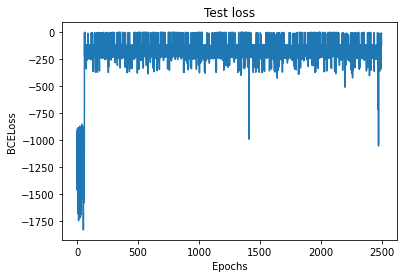

In [ ]:
config = {
    'batch_size': 64,
    'gamma': 0.99,
    'polyak': 0.99,
    'total_steps': 100000,
    'explr_steps': 6000,
    'buffer_size': 100000,
    'actor_lr': 0.001,
    'critic_lr': 0.001
}

task = Task.create(project_name='HW 4', task_name='Pendulum experiment')
task.connect(config)
logger = task.get_logger()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

env = gym.make("Pendulum-v1")
set_seeds(env)

num_states = env.observation_space.shape[0]
num_actions = env.action_space.shape[0]

critic = MLP((num_states + num_actions, 256, 256, num_actions)).to(DEVICE)
critic_target = MLP((num_states + num_actions, 256, 256, num_actions)).to(DEVICE)
polyak_average(critic_target, critic, 0)
actor =  Actor(2, layers_sizes=(num_states, 256, 256, num_actions), output_activation=nn.Tanh).to(DEVICE)
actor_target =  Actor(2, layers_sizes=(num_states, 256, 256, num_actions), output_activation=nn.Tanh).to(DEVICE)
polyak_average(actor_target, actor, 0)
actor_optim  = optim.Adam(actor.parameters(),  lr=config['actor_lr'])
critic_optim = optim.Adam(critic.parameters(), lr=config['critic_lr'])
action_noise = None
total_steps = config['total_steps']
explr_steps = config['explr_steps']
buffer_size = config['buffer_size']
batch_size = config['batch_size']
gamma = config['gamma']
polyak = config['polyak']

ddpg(env, actor, critic, actor_optim, critic_optim, action_noise,
     total_steps, buffer_size, batch_size, gamma, polyak, explr_steps,
     actor_target, critic_target)
task.close()

In [ ]:
#def make_gif(env_id, actor = None, n_episodes: int = 1, gif_name: str = "agent.gif", dir: str = "./gifs"):
make_gif("Pendulum-v1", actor, n_episodes=5)

In [ ]:
benchmark = Benchmark()
benchmark.run("Pendulum-v1", actor)


Starting Benchmark:
seed: 42
n_episodes: 100
Rewards: [-127.80044135940516, -235.4019718937698, -131.75583573177036, -240.91208453227762, -123.1610594693891, -125.58593872031535, -124.64003819405706, -128.74739852930372, -127.7231494461235, -250.75606178279938, -235.9340532757165, -225.99009689005393, -374.5531731756193, -235.57011345757851, -123.91398938614535, -123.6661057440471, -228.77608397897956, -231.72607267957994, -245.26293163893914, -232.46810874535217, -126.93539547917327, -221.93959978758363, -131.79106293520408, -124.55870579444873, -130.54475230735102, -238.46567779810582, -248.61234004428906, -230.38630508648805, -232.1365252580896, -232.56090322272073, -119.59760957939726, -123.88254371116889, -244.58171887474742, -7.487968885462944, -132.14548968541615, -240.14011003074452, -126.3281379592018, -120.91035836276019, -6.345264957408838, -122.70487719909794, -120.02590410485826, -124.84522727420938, -121.99968541130227, -242.90112334068203, -118.31274344536068, -125.7014

## Lunar Lander

124 -273.58272992444336
243 -101.41425260508045
321 -44.47964915368669
426 -241.4336023685636
606 -63.768485826485005
711 10.536237485017452
785 -65.08474641869353
877 -306.1325380325974
987 -76.93239180090568
1097 -71.56859373032924
1194 -60.762435032223
1275 -50.55239559525302
1496 -90.11952338447483
1572 -196.75865314408279
1675 -529.5478246542984
1751 -68.99930797922214
1855 -304.0216738917484
1952 -371.9063710318725
2127 -116.37232086087025
2237 -228.8574418085604
2338 -121.28469521324973
2442 -83.4623118101181
2529 -336.72810959527044
2629 -163.63591301867694
2734 -118.94591822055602
2802 -84.1900810048939
2890 -605.9760370971437
3004 -194.82238545616713
3089 -386.90498843530435
3177 -367.3253699718052
3274 -83.72501180689989
3422 -290.05664551707054
3561 -59.72177303381974
3722 -105.44530177612687
3812 -12.825534755372473
3948 -71.23323425217383
4089 -336.6303995692147
4159 -48.44232726544342
4247 -247.94987621606214
4325 -55.79150686629598
4451 -139.8726797487597
4554 -129.7016

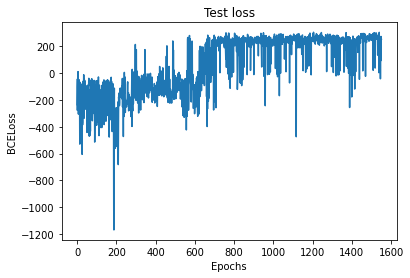

In [ ]:
config = {
    'batch_size': 64,
    'gamma': 0.99,
    'polyak': 0.99,
    'total_steps': 500000,
    'explr_steps': 20000,
    'buffer_size': 100000,
    'actor_lr': 0.0001,
    'critic_lr': 0.0001
}

task = Task.create(project_name='HW 4', task_name='Lunar Lander')
task.connect(config)
logger = task.get_logger()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

env_l = gym.make("LunarLanderContinuous-v2")
set_seeds(env_l)

num_states_l = env_l.observation_space.shape[0]
num_actions_l = env_l.action_space.shape[0]

critic_l = MLP((num_states_l + num_actions_l, 400, 200, num_actions_l)).to(DEVICE)
critic_target_l = MLP((num_states_l + num_actions_l, 400, 200, num_actions_l)).to(DEVICE)
polyak_average(critic_target_l, critic_l, 0)
actor_l =  Actor(1, layers_sizes=(num_states_l, 400, 200, num_actions_l), output_activation=nn.Tanh).to(DEVICE)
actor_target_l =  Actor(1, layers_sizes=(num_states_l, 400, 200, num_actions_l), output_activation=nn.Tanh).to(DEVICE)
polyak_average(actor_target_l, actor_l, 0)
actor_optim_l  = optim.Adam(actor_l.parameters(),  lr=config['actor_lr'])
critic_optim_l = optim.Adam(critic_l.parameters(), lr=config['critic_lr'])
action_noise_l = None
total_steps_l = config['total_steps']
explr_steps_l = config['explr_steps']
buffer_size_l = config['buffer_size']
batch_size_l = config['batch_size']
gamma_l = config['gamma']
polyak_l = config['polyak']

ddpg(env_l, actor_l, critic_l, actor_optim_l, critic_optim_l, action_noise_l,
     total_steps_l, buffer_size_l, batch_size_l, gamma_l, polyak_l, explr_steps_l,
     actor_target_l, critic_target_l)

In [ ]:
make_gif("LunarLanderContinuous-v2", actor_l, n_episodes=5)

In [ ]:
benchmark = Benchmark()
benchmark.run("LunarLanderContinuous-v2", actor_l)


Starting Benchmark:
seed: 42
n_episodes: 100
Rewards: [269.0654182142241, 218.22875950474327, 253.4024897789017, -141.86570650186565, 226.45677729150154, 268.44542286281865, -50.27739195373342, -50.408304556180326, 266.12038594374127, 249.3947263845769, 279.37065610775915, 233.26883537901668, 272.6309187139668, 245.74994133061782, 270.68063697520097, 260.24529992014175, 150.96996615174322, 279.87868266596763, 235.17796153181212, 271.5498473291159, 239.824221428999, 263.71307051412657, 252.0451472445874, 286.36062465947526, 279.05532039139297, 297.32809790738173, -7.590696883774471, 259.12770064202795, -31.022517160748215, -46.45711336156913, 279.6148337819209, 274.5886550240815, 274.04843049309204, -23.754382644708215, 262.8548080885139, 289.13027602835547, 264.45420422914367, 227.64096207370505, 213.5395897419674, 259.4141957443513, 218.6171958277627, 257.8542435478019, 257.42081959521806, 243.49779693571546, -134.7576086084843, 268.9698842617522, 260.735901839901, 283.27874802776273

## Training Mountain Car

998 -34.24459258703941
1997 -33.064774968242226
2996 -32.933203631879465
3995 -32.84024204548185
4994 -31.022927956049557
5993 -32.917762036125474
6992 -33.01724652195474
7991 -32.26462717730888
8990 -32.23565661098363
9989 -33.54415916946862
10988 -33.039175392064195
11987 -31.98671565340104
12986 -33.009697138053475
13985 -33.48248604059549
14984 -34.05167516639643
15983 -31.742337412234782
16982 -33.835527934926176
17981 -32.37221650694273
18980 -32.402661901192936
19979 -33.16848524692555
20978 -42.1077630900786
21977 -41.405974083595744
22976 -42.870452852323126
23975 -40.56818082832366
24974 -43.721247772926944
25855 62.48608345219784
26854 -44.58213727726819
27853 -45.374966451205516
28852 -43.22773091474355
29851 -46.542537487598274
30850 -46.6312512722669
31849 -45.57224043200665
32848 -42.57687574526578
33847 -42.825183179123
34846 -44.76997306896489
35453 71.543169611824
36452 -45.139672402636236
37439 56.66907256382194
38249 61.612624280622455
38780 73.63756358867306
39779 

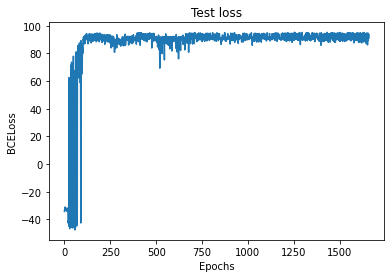

In [ ]:
config = {
    'batch_size': 256,
    'gamma': 0.99,
    'polyak': 0.999,
    'total_steps': 300000,
    'explr_steps': 20000,
    'buffer_size': 30000,
    'actor_lr': 0.0001,
    'critic_lr': 0.0001,
    'noise': 0.8
}

task = Task.create(project_name='HW 4', task_name='Mountain Car')
task.connect(config)
logger = task.get_logger()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

env_m = gym.make("MountainCarContinuous-v0")
set_seeds(env_m)

num_states_m = env_m.observation_space.shape[0]
num_actions_m = env_m.action_space.shape[0]

critic_m = MLP((num_states_m + num_actions_m, 256, 256, num_actions_m)).to(DEVICE)
critic_target_m = MLP((num_states_m + num_actions_m, 256, 256, num_actions_m)).to(DEVICE)
polyak_average(critic_target_m, critic_m, 0)
actor_m =  Actor(1, layers_sizes=(num_states_m, 256, 256, num_actions_m), output_activation=nn.Tanh).to(DEVICE)
actor_target_m =  Actor(1, layers_sizes=(num_states_m, 256, 256, num_actions_m), output_activation=nn.Tanh).to(DEVICE)
polyak_average(actor_target_m, actor_m, 0)
actor_optim_m  = optim.Adam(actor_m.parameters(),  lr=config['actor_lr'])
critic_optim_m = optim.Adam(critic_m.parameters(), lr=config['critic_lr'])
action_noise_m = None
total_steps_m = config['total_steps']
explr_steps_m = config['explr_steps']
buffer_size_m = config['buffer_size']
batch_size_m = config['batch_size']
gamma_m = config['gamma']
polyak_m = config['polyak']

ddpg(env_m, actor_m, critic_m, actor_optim_m, critic_optim_m, action_noise_m,
     total_steps_m, buffer_size_m, batch_size_m, gamma_m, polyak_m, explr_steps_m,
     actor_target_m, critic_target_m, noise=config['noise'])

In [ ]:
make_gif("MountainCarContinuous-v0", actor_m, n_episodes=5)

In [ ]:
benchmark = Benchmark()
benchmark.run("MountainCarContinuous-v0", actor_m)


Starting Benchmark:
seed: 42
n_episodes: 100
Rewards: [93.98591812029633, 94.0667391122978, 93.89378930431148, 94.06495803886679, 94.00919128621068, 93.97046597071929, 93.88685277264025, 93.98966424868537, 93.93488696638053, 93.97798728348415, 93.96020011443846, 93.92698622313736, 93.92756353714717, 93.86359598305552, 93.99549013720089, 93.99849410015504, 93.98306381721713, 93.82358042691614, 93.79446242376623, 93.9146615560805, 93.86120431412287, 93.88545877610316, 93.85487964220403, 93.82794515711116, 93.92833161562281, 94.01520727284309, 93.86498232640703, 93.99629962036933, 93.96908148192459, 93.8771636914583, 93.97687207825362, 93.84872580729984, 93.86352136003907, 93.98102073450647, 93.81713155352249, 94.04890746549144, 93.89264776922285, 93.94832082127913, 93.89173124473406, 94.04260637456328, 93.93448846305282, 93.83954289249166, 93.85265457293553, 93.90648775360619, 94.04546385271216, 93.91853570745258, 93.898558351924, 93.76031287212037, 94.04332147901846, 93.75272395449194,

# Analysis of different hyperparameters on Pendulum

[Results](https://app.clear.ml/projects/0c3bccba2089434ba749adb475b8cc31/experiments?columns=selected&columns=type&columns=name&columns=tags&columns=status&columns=project.name&columns=users&columns=started&columns=last_update&columns=last_iteration&columns=parent.name&order=-last_update&filter=
)

[Bulk plot comparison](https://app.clear.ml/projects/0c3bccba2089434ba749adb475b8cc31/compare-experiments;ids=39adb29d2aa6439c9e2b900bdb5f5446,f4aabe18ce4c49a585e832a2c7164ade,12c1b31fc69a4c5d88e6256626ba0402,11f829ca50544bfc92ad0021461a29a1,71c137e2de024cfd91ba5b15ed433078,a608396be0e34662a25ec9d83e9963fe/scalars/graph?scalars=graph)


As stated in the task description, DDPG is extremely sensitive when it comes to hyperparameters. \\
Changing some just by 20% of their 'working' value makes algorithm stop training.\\
But some hyperparameters are more sensitive than others, lets look at the results:

### Buffer size:

[Plot comparison](https://app.clear.ml/projects/0c3bccba2089434ba749adb475b8cc31/compare-experiments;ids=f4aabe18ce4c49a585e832a2c7164ade,39adb29d2aa6439c9e2b900bdb5f5446,a608396be0e34662a25ec9d83e9963fe/scalars/graph?scalars=graph)

Buffer sizes chosen:
- 1k (records last 5 games)
- 6k (last 30 games)
- 100k (last 500 games)

Critic and actor losses here although not quite similar to each other at the beginning but in the end they seem to train to similar values with 100k buffer on critic slightly behind.

Comparing rewards we see that they eventually seem to train to obtain very similar rewards with 1k buffer being slightly less stable than other 2.

They all trained to be successful on benchmars, so changing buffer by a factor o 100 barely modified whole training process.

### Tau (from Polyak Average)

[Plot comparison](https://app.clear.ml/projects/0c3bccba2089434ba749adb475b8cc31/compare-experiments;ids=12c1b31fc69a4c5d88e6256626ba0402,a608396be0e34662a25ec9d83e9963fe/scalars/graph?scalars=graph)

Above comparison is between my best model and model with modified Tau.

Tau was changed from 0.99 to 0.7, so by roughly 30%.

Comparing losses we can clearly see that this model is far from optimal, the actor loss seems to be stabilizing near 150k, on the other side critic loss looks like it would stabilize also near 0 with my best model but its far from that having loss of 6k at the very end (vs 70 from best model).

Rewards also seem to be stabilized, we can't even see clear distinction between exploration steps and the actual training which seems worrying.

Tau is extremely sensitive parameter and should be carefully chosen.

### Learning rate

[Plot comparison](https://app.clear.ml/projects/0c3bccba2089434ba749adb475b8cc31/compare-experiments;ids=11f829ca50544bfc92ad0021461a29a1,a608396be0e34662a25ec9d83e9963fe,71c137e2de024cfd91ba5b15ed433078/scalars/graph?scalars=graph)

Compared learning rates are:
- 0.01
- 0.001
- 0.0001

Comparing losses we can already see a clear loser, the 0.01 loss seems to be stabilized near 150k in actor and 4k in critic, which is definitely bigger than other two, the 0.0001 loss seems to have surprisingly greater deviation on actor than 0.001 loss but in both actor and critic they seem to stabilize near 0.

Looking at rewards 0.01 loss is out of the question being extremely bad on either of loss and rewards, but 0.0001 seems to be slightly behind 0.001 early in training but eventually catches up to 0.001 and they seem to be stabilizing in the same values.

### Summary

While DDPG is extremely sensitive on some parameters on other slightly different parameters seem to yield in more stabilized learning and when choosing right 'unstable' hyperparameters they probably should be in more stable territory, overall it's extremely hard to guess them.